In [51]:
import pylab as plt
import imageio
import os
import numpy as np
import pandas as pd
import time
import utils
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image,ImageReadMode
from torchvision import transforms

from torch.autograd import Function
from torch.autograd import Variable

from skimage.transform import resize
import cv2

In [2]:
def path_label_loader(path):
    """
    Args:
     path: Folder path containing subfolders of images
    Output:
     images: List of image path
     labels: Numpy array of labels
    """
    images = []
    labels = []
    
    for s_folder in os.listdir(path):
        label = int(''.join([s for s in s_folder if s.isdigit()]))
        img_folder = os.path.join(path, s_folder)
        
        for img in os.listdir(img_folder):
            if img.endswith(".jpg"):
                image_path = os.path.join(img_folder, img)
                images.append(image_path)
                labels.append(label)
                
    labels = np.array(labels) - 1
    images = np.array(images)
                
    return images, labels

In [3]:
class CustomImageDataset(Dataset):
    def __init__(self, img_dir,labels, transform = False):
        self.img_dir = img_dir
        self.transform = transform
        self.labels = labels


    def __len__(self):
        return len(self.img_dir)

    def __getitem__(self, idx):
        img_path = self.img_dir[idx]
        img = read_image(img_path, ImageReadMode.RGB).float()
        if self.transform != False:
            img = self.transform(img)
        label = self.labels[idx]
        
        return img, label

In [4]:
def create_data_loader(img_path, img_label, batch_size):
    transform = transforms.Compose([
        transforms.Resize(size = (128,128)),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])
        
    
    dataset = CustomImageDataset(img_path, img_label, transform)

    data_loader = DataLoader(
        dataset, batch_size=batch_size, shuffle=True
    )
    
    return data_loader

In [5]:
def eval_on_test_set(net, test_loader,is_cnn = True, verbose=1):
    
    total_error = 0
    batch_num = 0
    
    for test_data, test_label in test_loader:
        
        bs = test_label.shape[0]
        test_data=test_data.to(device)
        test_label=test_label.to(device)
        
        if is_cnn:
            inputs = test_data
        else:
            inputs = test_data.view(bs, 128*128*3)
        
        scores=net( inputs ) 

        error = utils.get_error( scores , test_label)

        total_error += error.item()
        
        batch_num += 1
        
    total_error = total_error / batch_num
    
    if verbose == 1:
        print( 'error rate on test set =', total_error*100 ,'percent\n')
        
    return total_error

In [6]:
def train_model(net, n_epoch, my_lr, train_loader, test_loader, is_cnn = True, momentum=0.9, verbose=1):
    """
    Train a given model with specified hyperparameters
    
    Args:
     net: NN model to be trained
     n_epoch: Number of epochs to train the model
     bs: Batch size for minibatch GD
     lr: Learning rate of GD
     train_data: Torch tensor of dim [N:rgb:width:height]
     train_label: Torch tensor of dim [N]
     verbose: Print out metrics during training if 1, default 1
    
    Output:
     net: Trained NN model
     records: Dictionary containing metrics history, including training loss/error for each epoch/minibatch, test error for each epoch
    """
    
    N = len(train_loader)
    
    net = net.to(device)
    
    train_loss_hist_mb = []
    train_loss_hist = []
    train_error_hist = []
    test_error_hist = []
    
    start=time.time()

    for epoch in range(1,n_epoch+1):

        if not epoch%5:
            my_lr = my_lr / 1.5

        # optimizer=torch.optim.SGD( net.parameters() , lr=my_lr, momentum=momentum )
        optimizer=torch.optim.Adam(net.parameters(), lr=my_lr)

        running_loss=0
        running_error=0
        num_batches=0
            
        for minibatch_data, minibatch_label in train_loader:


            # FORWARD AND BACKWARD PASS
            bs = minibatch_label.shape[0]

            optimizer.zero_grad()


            minibatch_data=minibatch_data.to(device)                
            minibatch_label=minibatch_label.to(device)

            if is_cnn:
                inputs = minibatch_data
            else:                    
                inputs = minibatch_data.view(bs, 128*128*3)


            inputs.requires_grad_()

            scores=net( inputs ) 

            loss =  criterion( scores , minibatch_label.long()) 

            loss.backward()
            
            optimizer.step()


            # COMPUTE STATS
            running_loss += loss.detach().item()

            error = utils.get_error( scores.detach() , minibatch_label)
            running_error += error.item()

            num_batches+=1   
            train_loss_hist_mb.append(running_error/num_batches)
                
        # AVERAGE STATS THEN DISPLAY
        total_loss = running_loss/num_batches
        total_error = running_error/num_batches
        elapsed = (time.time()-start)/60

        if verbose == 1:
            print('epoch=',epoch, '\t time=', elapsed,'min', '\t lr=', my_lr  ,'\t loss=', total_loss , '\t error=', total_error*100 ,'percent')
        test_error = eval_on_test_set(net, test_loader,is_cnn = is_cnn, verbose=verbose) 
        
        train_loss_hist.append(total_loss)
        train_error_hist.append(total_error)
        test_error_hist.append(test_error)
    
    records = {'train_loss_mb': train_loss_hist_mb,
              'train_loss': train_loss_hist,
              'train_error': train_error_hist,
              'test_error': test_error_hist}
        
    return records

## Classification Models

### MLP

In [7]:
class mlp(nn.Module):

    def __init__(self, input_size, hidden_size1, hidden_size2,  output_size):
        super(mlp , self).__init__()
        
        self.layer1 = nn.Linear(  input_size   , hidden_size1)
        self.layer2 = nn.Linear(  hidden_size1 , hidden_size2)
        self.layer3 = nn.Linear(  hidden_size2 , output_size)
        
    def forward(self, x):
        
        y       = self.layer1(x)
        y_hat   = torch.relu(y)
        z       = self.layer2(y_hat)
        z_hat   = torch.relu(z)
        scores  = self.layer3(z_hat)
        
        return scores

### LeNet

In [129]:
class LeNet5_convnet(nn.Module):

    def __init__(self):

        super(LeNet5_convnet, self).__init__()
        
        self.layer = nn.Sequential(
            # CL1:   3 * 128 x 128  -->    50 x 128 x 128 
            nn.Conv2d(3,   50,  kernel_size=3,  padding=1 ),
            nn.ReLU(),

            # MP1: 50 x 128 x 128 -->    50 x 64 x 64
            nn.MaxPool2d(2,2),

            # CL2:   50 x 64 x 64  -->    100 x 64 x 64 
            nn.Conv2d(50,  100,  kernel_size=3,  padding=1 ),
            nn.ReLU(),

            # MP2: 100 x 64 x 64 -->    100 x 32 x 32
            nn.MaxPool2d(2,2),
            
            # MP3: 100 * 32 * 32 -> 100 * 32 * 32 (Grad needed for later CAM)
            nn.Conv2d(100,100, kernel_size=3, padding=1),
            nn.ReLU()
        )
        
        self.fc_layer = nn.Sequential(
            # LL1:   100 x 32 x 32 = 102400 -->  100 
            nn.Linear(102400, 100),
            nn.ReLU(),

            # LL2:   100  -->  13 
            nn.Linear(100,13),
        )

#         # CL1:   3 * 128 x 128  -->    50 x 128 x 128 
#         self.conv1 = nn.Conv2d(3,   50,  kernel_size=3,  padding=1 )
        
#         # MP1: 50 x 128 x 128 -->    50 x 64 x 64
#         self.pool1  = nn.MaxPool2d(2,2)
        
#         # CL2:   50 x 64 x 64  -->    100 x 64 x 64 
#         self.conv2 = nn.Conv2d(50,  100,  kernel_size=3,  padding=1 )
        
#         # MP2: 100 x 64 x 64 -->    100 x 32 x 32
#         self.pool2 = nn.MaxPool2d(2,2)
        
#         # LL1:   100 x 32 x 32 = 102400 -->  100 
#         self.linear1 = nn.Linear(102400, 100)
        
#         # LL2:   100  -->  13 
#         self.linear2 = nn.Linear(100,13)


    def forward(self, x):
        out = self.layer(x)
        out = out.view(-1, 102400)
        out = self.fc_layer(out)

#         # CL1:   128 x 28  -->    50 x 28 x 28 
#         x = self.conv1(x)
#         x = torch.relu(x)
        
#         # MP1: 50 x 28 x 28 -->    50 x 14 x 14
#         x = self.pool1(x)
        
#         # CL2:   50 x 14 x 14  -->    100 x 14 x 14
#         x = self.conv2(x)
#         x = torch.relu(x)
        
#         # MP2: 100 x 14 x 14 -->    100 x 7 x 7
#         x = self.pool2(x)

#         # LL1:   100 x 7 x 7 = 4900  -->  100 
#         x = x.view(-1, 102400)
#         x = self.linear1(x)
#         x = torch.relu(x)
        
#         # LL2:   4900  -->  10 
#         x = self.linear2(x)
    
        return out

## Load Data

In [9]:
path = "../data/clean_images_index"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device, "is running")

images, labels = path_label_loader(path)
print(len(images))
print(len(labels))

cuda is running
2061
2061


In [10]:
np.unique(labels, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 array([156, 152, 156, 170, 150, 129, 178, 141, 185, 159, 152, 161, 172],
       dtype=int64))

In [11]:
# Use 1648 images as training set and 413 images as test set
train_indice = np.random.choice(2061, 1648, replace=False)
train_path = images[train_indice]
train_label = labels[train_indice]
test_path = images[~train_indice]
test_label = labels[~train_indice]

In [12]:
train_loader = create_data_loader(train_path, train_label, 32)
test_loader = create_data_loader(test_path, test_label, 32)
criterion = nn.CrossEntropyLoss()

## Classification Model Training

In [13]:
my_mlp=mlp(128*128*3, 50, 50, 13)
my_mlp.to(device)
print(my_mlp)

mlp(
  (layer1): Linear(in_features=49152, out_features=50, bias=True)
  (layer2): Linear(in_features=50, out_features=50, bias=True)
  (layer3): Linear(in_features=50, out_features=13, bias=True)
)


In [17]:
mlp_record = train_model(net = my_mlp, n_epoch = 10, my_lr = 1e-4, train_loader = train_loader, test_loader = test_loader,is_cnn = False, verbose=1)

epoch= 1 	 time= 0.1922277530034383 min 	 lr= 0.0001 	 loss= 353036.9256910269 	 error= 92.54807692307693 percent
error rate on test set = 92.8485576923077 percent

epoch= 2 	 time= 0.5093631148338318 min 	 lr= 0.0001 	 loss= 38.90050524014693 	 error= 92.24759615384616 percent
error rate on test set = 92.90865384615384 percent

epoch= 3 	 time= 0.8266697525978088 min 	 lr= 0.0001 	 loss= 2.6318547129631042 	 error= 91.82692307692307 percent
error rate on test set = 91.76682692307693 percent

epoch= 4 	 time= 1.1481894731521607 min 	 lr= 0.0001 	 loss= 2.5993426258747396 	 error= 91.5264423076923 percent
error rate on test set = 91.82692307692307 percent

epoch= 5 	 time= 1.4695101062456766 min 	 lr= 6.666666666666667e-05 	 loss= 2.5824398398399353 	 error= 91.70673076923077 percent
error rate on test set = 91.82692307692307 percent

epoch= 6 	 time= 1.7918424169222513 min 	 lr= 6.666666666666667e-05 	 loss= 2.575266416256244 	 error= 91.58653846153845 percent
error rate on test set = 

In [130]:
my_lenet = LeNet5_convnet()
my_lenet.to(device)
print(my_lenet)

LeNet5_convnet(
  (layer): Sequential(
    (0): Conv2d(3, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(50, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(100, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
  )
  (fc_layer): Sequential(
    (0): Linear(in_features=102400, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=13, bias=True)
  )
)


In [131]:
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(my_lenet.parameters(), lr=1e-4)
model = my_lenet

num_epoch = 10
for i in range(num_epoch):
    my_lenet.train()
    for j,[image,label] in enumerate(train_loader):
        x = Variable(image).cuda()
        y_= Variable(label).cuda()
        
        optimizer.zero_grad()
        output = model.forward(x)
        loss = loss_func(output,y_.long())
        loss.backward()
        optimizer.step()
        
         
    top_1_count = torch.FloatTensor([0])
    total = torch.FloatTensor([0])
    model.eval() 
    for image,label in test_loader:
        x = Variable(image,volatile=True).cuda()
        y_= Variable(label).cuda()

        output = model.forward(x)
        
        values,idx = output.max(dim=1)
        top_1_count += torch.sum(y_==idx).float().cpu().data

        total += label.size(0)

    print("Test Data Accuracy: {}%".format(100*(top_1_count/total).numpy()))
    if (top_1_count/total).numpy() > 0.98:
        break

KeyboardInterrupt: 

In [132]:
lenet_record = train_model(net = my_lenet, n_epoch = 10, my_lr = 1e-4, train_loader = train_loader, test_loader = test_loader, verbose=1)

epoch= 1 	 time= 0.24891521135965983 min 	 lr= 0.0001 	 loss= 1.977517545223236 	 error= 63.942307692307686 percent
error rate on test set = 28.365384615384613 percent

epoch= 2 	 time= 0.6829716642697652 min 	 lr= 0.0001 	 loss= 0.682831197977066 	 error= 21.033653846153847 percent
error rate on test set = 11.778846153846153 percent

epoch= 3 	 time= 1.117778734366099 min 	 lr= 0.0001 	 loss= 0.17946368634987336 	 error= 5.709134615384615 percent
error rate on test set = 11.778846153846153 percent

epoch= 4 	 time= 1.567105491956075 min 	 lr= 0.0001 	 loss= 0.10663171490439428 	 error= 2.1033653846153846 percent
error rate on test set = 9.375 percent

epoch= 5 	 time= 1.9918669978777568 min 	 lr= 6.666666666666667e-05 	 loss= 0.01919112167692779 	 error= 0.4807692307692308 percent
error rate on test set = 9.314903846153847 percent



KeyboardInterrupt: 

In [57]:
# import pickle
# file_to_store = open("lenet.pickle", "wb")
# pickle.dump(my_lenet, file_to_store)


# file_to_store.close()

In [18]:
# import pickle
# file_to_read = open("lenet.pickle", "rb")

# my_lenet = pickle.load(file_to_read)

# file_to_read.close()

## Guided Backprop ReLU

In [133]:
class GuidedBackpropRelu(Function):
    @staticmethod
    def forward(ctx,input):
        ctx.save_for_backward(input)
        return input.clamp(min=0)
    
    @staticmethod
    def backward(ctx,grad_output):
        input = ctx.saved_tensors[0]
        grad_input = grad_output.clone()
        grad_input[grad_input<0] = 0
        grad_input[input<0]=0
        return grad_input
     
guided_relu = GuidedBackpropRelu.apply

## Guided Backprop ReLU Model

In [134]:
class GuidedReluModel(nn.Module):
    def __init__(self,model,to_be_replaced,replace_to):
        super(GuidedReluModel,self).__init__()
        self.model = model
        self.to_be_replaced = to_be_replaced
        self.replace_to = replace_to
        self.layers=[]
        self.output=[]
        
        for m in self.model.modules():
            if isinstance(m,self.to_be_replaced):
                self.layers.append(self.replace_to )
                #self.layers.append(m)
            elif isinstance(m,nn.Conv2d):
                self.layers.append(m)
            elif isinstance(m,nn.BatchNorm2d):
                self.layers.append(m)
            elif isinstance(m,nn.Linear):
                self.layers.append(m)
            elif isinstance(m,nn.AvgPool2d):
                self.layers.append(m)
            elif isinstance(m,nn.MaxPool2d):
                self.layers.append(m)
                
        for i in self.layers:
            print(i)
        
        
    def reset_output(self):
        self.output = []
    
    def hook(self,grad):
        # out = grad[:,0,:,:].cpu().data#.numpy()
        out = grad[:,:,:,:].cpu().data#.numpy()
        print("out_size:",out.size())
        self.output.append(out)
        
    def get_visual(self,idx,original_img):
        grad = self.output[0][idx]
        return grad
        
    def forward(self,x):
        out = x 
        out.register_hook(self.hook)
        for i in self.layers[:-3]:
            out = i(out)
        out = out.view(out.size()[0],-1)
        for j in self.layers[-3:]:
            out = j(out)
        return out
    
    # def forward(self,x):
    #     out = x 
    #     out.register_hook(self.hook)
    #     for i in self.layers:
    #         out = i(out)
    #     out = out.view(out.size()[0],-1)
    #     # out = out.view(-1, 102400)
    #     return out
        

In [194]:
def axes_swap(x):
    '''Convert (3,n,n) to (n,n,3)'''
    x = x.swapaxes(0,1)
    x = x.swapaxes(1,2)
    return x

In [214]:
product = None

## Class Activation Map (CAM)

In [221]:
class CAM():
    def __init__(self,model):
        self.gradient = []
        self.model = model
        # self.h = self.model.model.layer[-2].register_backward_hook(self.save_gradient)
        self.h = self.model.model.layer[0].register_backward_hook(self.save_gradient) ## Note the change of index here, the indexed layer should have grad?
        
    def save_gradient(self,*args):
        #print("Gradient saved!!!!")
        grad_input = args[1]
        grad_output= args[2]
        self.gradient.append(grad_output[0])
        print('CAM grad: ', self.gradient[0].size())
        
    def get_gradient(self):
        return self.gradient[0]
    
    def remove_hook(self):
        self.h.remove()
            
    def normalize_cam(self,x):
        x = 2*(x-torch.min(x))/(torch.max(x)-torch.min(x)+1e-8)-1
        #x[x<torch.max(x)]=-1
        return x
    
    def visualize(self,cam_img,guided_img,img_var):
        # guided_img = guided_img.sum(dim=0) # Compress RGB dimension? 
        guided_img = guided_img.numpy()
        # cam_img = resize(cam_img.cpu().data.numpy(),output_shape=(28,28))
        cam_img = cam_img.cpu().data.numpy()
        x = img_var[:,:,:].cpu().data.numpy()
        
        x = axes_swap(x)
        guided_img = axes_swap(guided_img)
        # print('guided_img shape:',guided_img.shape)
        guided_img = np.sum(guided_img, axis=-1)
        # print('guided_img max:', guided_img.max())
        # print('x_max:', x.max())
        # print(x.shape)
        
        # x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)

        fig = plt.figure(figsize=(20, 12)) 
        
        plt.subplot(1,4,1)
        plt.title("Original Image")
        # plt.imshow(x,cmap="gray")
        plt.imshow(x)

        plt.subplot(1,4,2)
        plt.title("Class Activation Map")
        plt.imshow(cam_img)

        plt.subplot(1,4,3)
        plt.title("Guided Backpropagation")
        # plt.imshow(guided_img,cmap='gray')
        plt.imshow(guided_img)
        
        plt.subplot(1,4,4)
        plt.title("Guided x CAM")
        # plt.imshow(guided_img*cam_img,cmap="gray")
        global product
        product = guided_img*cam_img
        plt.imshow(guided_img*cam_img)
        plt.show()
    
    def get_cam(self,idx):
        grad = self.get_gradient()
        print('grad shape:', grad.shape)
        alpha = torch.sum(grad,dim=3,keepdim=True)
        alpha = torch.sum(alpha,dim=2,keepdim=True)
        print('alpha shape:', alpha.shape)
        
        cam = alpha[idx]*grad[idx]
        cam = torch.sum(cam,dim=0) # Default Compression(of features?)
        cam = self.normalize_cam(cam)
        self.remove_hook()
        
        return cam

## Detection Model

In [222]:
model = my_lenet ## Change when best model is used
guide = GuidedReluModel(model,nn.ReLU,guided_relu)
cam = CAM(guide)

Conv2d(3, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
<built-in method apply of FunctionMeta object at 0x0000028E07CA86D8>
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Conv2d(50, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
<built-in method apply of FunctionMeta object at 0x0000028E07CA86D8>
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Conv2d(100, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
<built-in method apply of FunctionMeta object at 0x0000028E07CA86D8>
Linear(in_features=102400, out_features=100, bias=True)
<built-in method apply of FunctionMeta object at 0x0000028E07CA86D8>
Linear(in_features=100, out_features=13, bias=True)


guided out shape:  torch.Size([32, 13])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


out_size: torch.Size([32, 3, 128, 128])
grad shape: torch.Size([32, 50, 128, 128])
alpha shape: torch.Size([32, 50, 1, 1])


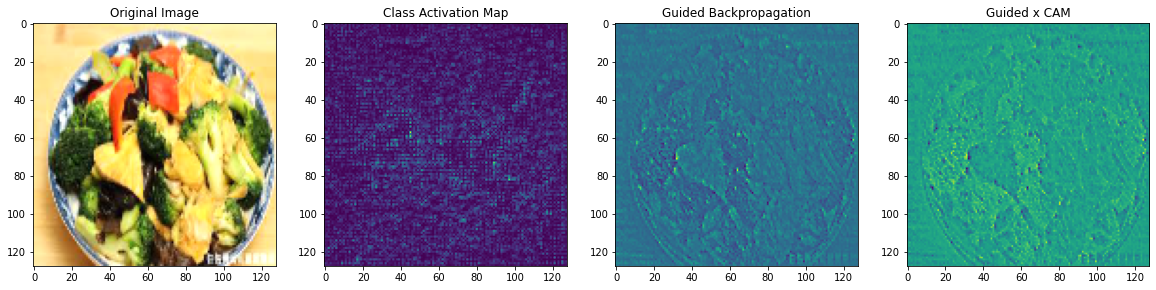

In [228]:
guide.reset_output()
for image,label in test_loader:
    x = Variable(image,requires_grad=True).cuda()
    x = x/255./4.
    y_= Variable(label).cuda()
        
    output = guide.forward(x) 
    # print(output[0])
    output = torch.index_select(output,dim=1,index=y_)
    # print(output[0])
    output = torch.sum(output)
    # print(output)
    output.backward(retain_graph=True)
    
    for j in range(1):
        out = cam.get_cam(j)
        guided_img = guide.get_visual(j,x)
        cam.visualize(out,guided_img,x[j])
        
    break

In [229]:
print(product.max())
print(product.min())

0.0046479916
-0.006860629


In [246]:
np.unravel_index(product.argmax(), product.shape)

(61, 124)

In [247]:
product[61,124]

0.0046479916

In [248]:
np.unravel_index(product.argmin(), product.shape)

(71, 32)

In [249]:
product[71, 32]

-0.006860629

In [252]:
product[71,:]

array([ 7.60259136e-05,  4.62504482e-04,  2.57582171e-04,  1.22866375e-04,
        5.14240237e-05, -2.98745173e-04, -2.70631688e-04, -8.00759939e-04,
        1.12748879e-03,  5.27403899e-04,  7.15928734e-04,  4.63739940e-04,
       -4.83435870e-04, -6.95504539e-04, -3.91108129e-04, -1.22800854e-03,
        1.97949540e-03,  1.03177445e-03, -1.26433745e-03, -2.49288627e-03,
        3.31984926e-03, -4.42736055e-05, -1.82687232e-04,  7.69664184e-05,
        4.59793751e-04,  6.11355237e-04,  2.61663157e-03, -2.29731493e-04,
        4.41597134e-04, -1.27499597e-03,  1.99562800e-03,  2.53773341e-03,
       -6.86062919e-03, -3.21179256e-03,  4.24749422e-04, -5.73382771e-04,
        7.35355570e-05, -3.22309032e-04, -4.40936274e-04, -1.12076625e-04,
       -2.43018803e-04, -5.83966612e-04, -5.34139981e-04, -2.33747996e-04,
       -2.95509817e-04, -4.41350858e-04, -2.32018065e-04,  6.67050539e-04,
       -7.02945457e-04, -1.17726384e-04, -2.00077353e-04, -9.88958753e-04,
       -7.63178745e-04,  

In [261]:
pic = axes_swap(x[j]).cpu().data.numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


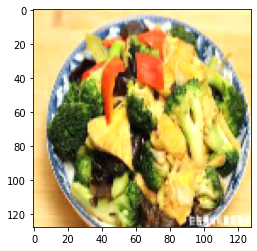

In [262]:
plt.imshow(pic)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


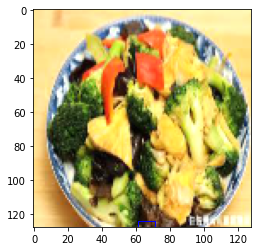

In [269]:
import matplotlib.patches as patches
fig, ax = plt.subplots()

# Display the image
ax.imshow(pic)

# Create a Rectangle patch
rect = patches.Rectangle(np.unravel_index(product.argmax(), product.shape), 10, 10, linewidth=1, edgecolor='b', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)